## Problem Statment

Develop a machine learning model that can accurately classify the chest X- ray images as normal or pneumonia

In [ ]:
pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob, pylab
import pydicom, gc
import os
from pathlib import Path
import random
import csv
from tqdm import tqdm
import cv2

In [ ]:
train_path = os.path.join('/content/drive/MyDrive/rsna_pneumonia/stage_2_train_images')
test_path = os.path.join('/content/drive/MyDrive/rsna_pneumonia/stage_2_test_images')

In [ ]:
train_images = os.listdir(train_path)
test_images = os.listdir(test_path)

In [ ]:
print(len(train_images), len(test_images))

26684 3000


In [ ]:
labels = pd.read_csv('/content/drive/MyDrive/rsna_pneumonia/stage_2_train_labels.csv')
labels.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [ ]:
labels.head(10)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1


In [ ]:
labels.shape

(30227, 6)

In [ ]:
labels['patientId'].nunique()

26684

In [ ]:
labels['Target'].value_counts()

0    20672
1     9555
Name: Target, dtype: int64

In [ ]:
classes = pd.read_csv('/content/drive/MyDrive/rsna_pneumonia/stage_2_detailed_class_info.csv')
classes.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [ ]:
classes['patientId'].nunique()

26684

In [ ]:
classes['class'].value_counts()

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64

In [ ]:
data = pd.merge(left = labels, right = classes, how = 'left', on = 'patientId')
data.shape

(37629, 7)

In [ ]:
data['patientId'].nunique()

26684

In [ ]:
# print('Number of Duplicated records in data file:', data.duplicated().sum())

In [ ]:
# data.drop_duplicates(inplace = True)

In [ ]:
# print('Number of Duplicated records in data file:', data.duplicated().sum())

<Axes: xlabel='Target', ylabel='count'>

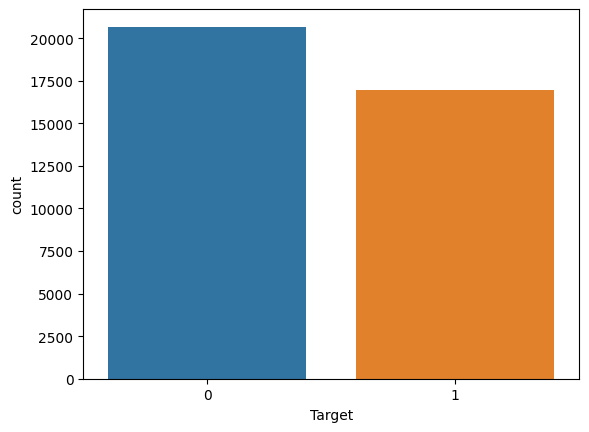

In [ ]:
# distribution of target
sns.countplot(x='Target', data=data)

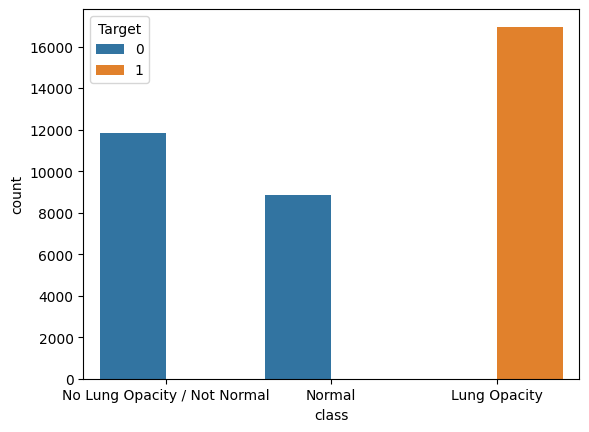

In [ ]:
# distribution of class
sns.countplot(x = 'class', hue = 'Target', data = data);

In [ ]:
patientId = data['patientId'][0]
dcm_file = '/content/drive/MyDrive/rsna_pneumonia/stage_2_train_images/%s.dcm' % patientId
dcm_data = pydicom.read_file(dcm_file)
print(dcm_data)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

(-0.5, 1023.5, 1023.5, -0.5)

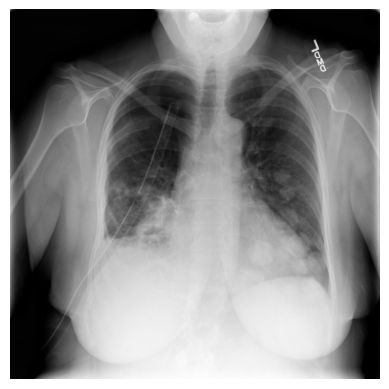

In [ ]:
img = dcm_data.pixel_array
pylab.imshow(img, cmap=pylab.cm.gist_gray)
pylab.axis('off')

In [ ]:
train_data = data.copy()

In [ ]:
# List of information needed
vars = ['PatientAge','PatientSex']


def process_dicom_data(df, path):
    
    # adding new columns to the imported DataFrame with Null values
    for var in vars:
        df[var] = None
        
    images = os.listdir(path)
    
    #looping through each dicom image, extract the information from it, and 
    # add it to the DataFrame
    
    for i, img_name in tqdm(enumerate(images)):
        
        imagePath = os.path.join(path,img_name)
        img_data = pydicom.read_file(imagePath)
        
        idx = (df['patientId']==img_data.PatientID)
        df.loc[idx,'PatientAge'] = pd.to_numeric(img_data.PatientAge)
        df.loc[idx,'PatientSex'] = img_data.PatientSex
        # df.loc[idx, 'ImagePath'] = str.format(imagePath)

process_dicom_data(train_data,'/content/drive/MyDrive/rsna_pneumonia/stage_2_train_images')

26684it [04:39, 95.47it/s] 


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37629 entries, 0 to 37628
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   patientId   37629 non-null  object 
 1   x           16957 non-null  float64
 2   y           16957 non-null  float64
 3   width       16957 non-null  float64
 4   height      16957 non-null  float64
 5   Target      37629 non-null  int64  
 6   class       37629 non-null  object 
 7   PatientAge  37629 non-null  object 
 8   PatientSex  37629 non-null  object 
dtypes: float64(4), int64(1), object(4)
memory usage: 3.9+ MB


In [ ]:
train_data['PatientAge'] = train_data.PatientAge.astype(int)

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37629 entries, 0 to 37628
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   patientId   37629 non-null  object 
 1   x           16957 non-null  float64
 2   y           16957 non-null  float64
 3   width       16957 non-null  float64
 4   height      16957 non-null  float64
 5   Target      37629 non-null  int64  
 6   class       37629 non-null  object 
 7   PatientAge  37629 non-null  int64  
 8   PatientSex  37629 non-null  object 
dtypes: float64(4), int64(2), object(3)
memory usage: 3.9+ MB


In [ ]:
train_data.describe(include='all')

,patientId,x,y,width,height,Target,class,PatientAge,PatientSex
count,37629,16957.000000,16957.000000,16957.000000,16957.000000,37629.000000,37629,37629.000000,37629
unique,26684,NaN,NaN,NaN,NaN,NaN,3,NaN,2
top,3239951b-6211-4290-b237-3d9ad17176db,NaN,NaN,NaN,NaN,NaN,Lung Opacity,NaN,M
freq,16,NaN,NaN,NaN,NaN,NaN,16957,NaN,21498
mean,NaN,398.980008,360.443121,219.266675,337.799552,0.450636,NaN,46.482394,NaN
std,NaN,204.869392,149.202409,59.195268,158.986899,0.497564,NaN,17.008911,NaN
min,NaN,2.000000,2.000000,40.000000,45.000000,0.000000,NaN,1.000000,NaN
25%,NaN,209.000000,243.000000,178.000000,210.000000,0.000000,NaN,33.000000,NaN
50%,NaN,343.000000,355.000000,218.000000,309.000000,0.000000,NaN,48.000000,NaN
75%,NaN,596.000000,472.000000,259.000000,452.000000,1.000000,NaN,59.000000,NaN


In [ ]:
train_data[train_data['patientId'] == '3239951b-6211-4290-b237-3d9ad17176db']

,patientId,x,y,width,height,Target,class,PatientAge,PatientSex
3411,3239951b-6211-4290-b237-3d9ad17176db,511.0,249.0,188.0,232.0,1,Lung Opacity,35,F
3412,3239951b-6211-4290-b237-3d9ad17176db,511.0,249.0,188.0,232.0,1,Lung Opacity,35,F
3413,3239951b-6211-4290-b237-3d9ad17176db,511.0,249.0,188.0,232.0,1,Lung Opacity,35,F
3414,3239951b-6211-4290-b237-3d9ad17176db,511.0,249.0,188.0,232.0,1,Lung Opacity,35,F
3415,3239951b-6211-4290-b237-3d9ad17176db,558.0,649.0,174.0,186.0,1,Lung Opacity,35,F
3416,3239951b-6211-4290-b237-3d9ad17176db,558.0,649.0,174.0,186.0,1,Lung Opacity,35,F
3417,3239951b-6211-4290-b237-3d9ad17176db,558.0,649.0,174.0,186.0,1,Lung Opacity,35,F
3418,3239951b-6211-4290-b237-3d9ad17176db,558.0,649.0,174.0,186.0,1,Lung Opacity,35,F
3419,3239951b-6211-4290-b237-3d9ad17176db,152.0,661.0,191.0,145.0,1,Lung Opacity,35,F
3420,3239951b-6211-4290-b237-3d9ad17176db,152.0,661.0,191.0,145.0,1,Lung Opacity,35,F


In [ ]:
train_data.drop_duplicates(inplace=True)

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30227 entries, 0 to 37627
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   patientId   30227 non-null  object 
 1   x           9555 non-null   float64
 2   y           9555 non-null   float64
 3   width       9555 non-null   float64
 4   height      9555 non-null   float64
 5   Target      30227 non-null  int64  
 6   class       30227 non-null  object 
 7   PatientAge  30227 non-null  int64  
 8   PatientSex  30227 non-null  object 
dtypes: float64(4), int64(2), object(3)
memory usage: 2.3+ MB


In [ ]:
train_data.rename(columns={'x':'x0','y':'y0'}, inplace = True)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30227 entries, 0 to 37627
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   patientId   30227 non-null  object 
 1   x0          9555 non-null   float64
 2   y0          9555 non-null   float64
 3   width       9555 non-null   float64
 4   height      9555 non-null   float64
 5   Target      30227 non-null  int64  
 6   class       30227 non-null  object 
 7   PatientAge  30227 non-null  int64  
 8   PatientSex  30227 non-null  object 
dtypes: float64(4), int64(2), object(3)
memory usage: 2.3+ MB


In [ ]:
images = []
ADJUSTED_IMAGE_SIZE = 128
imageList = []
classLabels = []
labels = []
originalImage = []

def readAndReshapeImage(image):
    img = np.array(image).astype(np.uint8)
    res = cv2.resize(img,(ADJUSTED_IMAGE_SIZE,ADJUSTED_IMAGE_SIZE), interpolation = cv2.INTER_LINEAR)
    return res

def populateImage(rowData):
    for index, row in rowData.iterrows():
        patientId = row.patientId
        classlabel = row["class"]
        dcm_file = '/content/drive/MyDrive/rsna_pneumonia/stage_2_train_images/'+'{}.dcm'.format(patientId)
        dcm_data = pydicom.read_file(dcm_file)
        img = dcm_data.pixel_array
        
        ## Converting the image to 3 channels as the dicom image pixel does not have colour classes wiht it
        if len(img.shape) != 3 or img.shape[2] != 3:
            img = np.stack((img,) * 3, -1)
        
        imageList.append(readAndReshapeImage(img))
#         originalImage.append(img)
        classLabels.append(classlabel)
    tmpImages = np.array(imageList)
    tmpLabels = np.array(classLabels)
#     originalImages = np.array(originalImage)
    return tmpImages,tmpLabels

images, labels = populateImage(train_data)
print(images.shape , labels.shape)

(30227, 128, 128, 3) (30227,)


In [ ]:
from sklearn.preprocessing import LabelBinarizer
encode = LabelBinarizer()
y = encode.fit_transform(labels)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(images, y, test_size=0.2, random_state=47)

In [ ]:
from keras.layers import Layer, Convolution2D, Flatten, Dense
from keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.layers import Dense, Activation,Flatten,Dropout,MaxPooling2D,BatchNormalization

from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras import losses,optimizers

In [ ]:
from sklearn.metrics import average_precision_score

In [ ]:
# making a sample dataset of 6000 items from original dataset
sample = train_data.groupby('class', group_keys=False).apply(lambda x: x.sample(2000))

In [ ]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 35955 to 17570
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   patientId   6000 non-null   object 
 1   x0          2000 non-null   float64
 2   y0          2000 non-null   float64
 3   width       2000 non-null   float64
 4   height      2000 non-null   float64
 5   Target      6000 non-null   int64  
 6   class       6000 non-null   object 
 7   PatientAge  6000 non-null   int64  
 8   PatientSex  6000 non-null   object 
dtypes: float64(4), int64(2), object(3)
memory usage: 468.8+ KB


In [ ]:
sample['class'].value_counts()

Lung Opacity                    2000
No Lung Opacity / Not Normal    2000
Normal                          2000
Name: class, dtype: int64

In [ ]:
images = []
ADJUSTED_IMAGE_SIZE = 128
imageList = []
classLabels = []
labels = []
originalImage = []

def readAndReshapeImage(image):
    img = np.array(image).astype(np.uint8)
    res = cv2.resize(img,(ADJUSTED_IMAGE_SIZE,ADJUSTED_IMAGE_SIZE), interpolation = cv2.INTER_LINEAR)
    return res

def populateImage(rowData):
    for index, row in rowData.iterrows():
        patientId = row.patientId
        classlabel = row["class"]
        dcm_file = '/content/drive/MyDrive/rsna_pneumonia/stage_2_train_images/'+'{}.dcm'.format(patientId)
        dcm_data = pydicom.read_file(dcm_file)
        img = dcm_data.pixel_array
        
        ## Converting the image to 3 channels as the dicom image pixel does not have colour classes wiht it
        if len(img.shape) != 3 or img.shape[2] != 3:
            img = np.stack((img,) * 3, -1)
        
        imageList.append(readAndReshapeImage(img))
#         originalImage.append(img)
        classLabels.append(classlabel)
    tmpImages = np.array(imageList)
    tmpLabels = np.array(classLabels)
#     originalImages = np.array(originalImage)
    return tmpImages,tmpLabels

images, labels = populateImage(sample)
print(images.shape , labels.shape)

(6000, 128, 128, 3) (6000,)


In [ ]:
from sklearn.preprocessing import LabelBinarizer
encode = LabelBinarizer()
y = encode.fit_transform(labels)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(images, y, test_size=0.2, random_state=47)

## Modeling

In [ ]:
# create the model
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu', input_shape = (128,128,3)))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.4))
model.add(GlobalMaxPooling2D())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(3, activation = "softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 64, 64, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 64)        36928     
                                                      

In [ ]:
# compile the model
model.compile(optimizer = "adam", loss = "categorical_crossentropy",
               metrics = ['accuracy'])

In [ ]:
## Training for 20 epocs with batch size of 16
epoch = 20
history = model.fit(X_train, 
                  y_train, 
                  epochs = epoch, 
                  validation_data = (X_val,y_val),
                  batch_size = 16)

Epoch 1/20
300/300 [==============================] - 716s 2s/step - loss: 2.0545 - accuracy: 0.3556 - val_loss: 1.0794 - val_accuracy: 0.4025
Epoch 2/20
300/300 [==============================] - 707s 2s/step - loss: 1.0635 - accuracy: 0.4177 - val_loss: 1.0583 - val_accuracy: 0.4675
Epoch 3/20
300/300 [==============================] - 705s 2s/step - loss: 1.0459 - accuracy: 0.4390 - val_loss: 1.0255 - val_accuracy: 0.4792
Epoch 4/20
300/300 [==============================] - 709s 2s/step - loss: 1.0398 - accuracy: 0.4567 - val_loss: 1.0501 - val_accuracy: 0.4625
Epoch 5/20
300/300 [==============================] - 709s 2s/step - loss: 1.0315 - accuracy: 0.4683 - val_loss: 1.0167 - val_accuracy: 0.5083
Epoch 6/20
300/300 [==============================] - 707s 2s/step - loss: 1.0200 - accuracy: 0.4831 - val_loss: 1.0070 - val_accuracy: 0.5067
Epoch 7/20
300/300 [==============================] - 712s 2s/step - loss: 1.0135 - accuracy: 0.4860 - val_loss: 1.0126 - val_accuracy: 0.5217

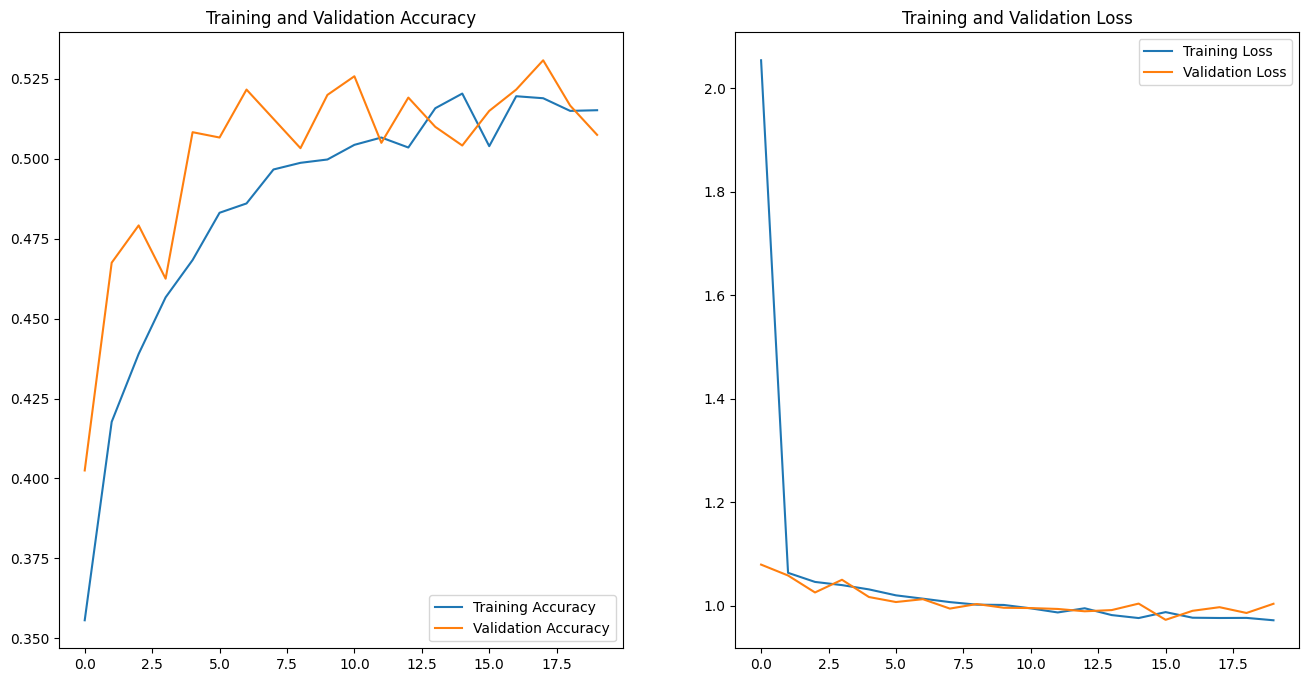

In [ ]:
# visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epoch)

plt.figure(figsize = (16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

##VGGNet is a well-documented and globally used architecture for convolutional neural network
## Include_top=False to remove the classification layer that was trained on the ImageNet dataset and set the model as not trainable

base_model = VGG16(weights="imagenet", include_top=False, input_shape=X_train[0].shape)
base_model.trainable = False ## Not trainable weights

## Preprocessing input
train_ds = preprocess_input(X_train) 
train_val_df = preprocess_input(X_val)

58889256/58889256 [==============================] - 1s 0us/step


In [ ]:
flatten_layer = Flatten()
dense_layer_1 = Dense(50, activation='relu')
dense_layer_2 = Dense(20, activation='relu')
prediction_layer = Dense(3, activation='softmax')


VGG16_model = Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [ ]:
# compile the model
VGG16_model.compile(optimizer = 'Adam', loss = "categorical_crossentropy", metrics=['accuracy'])

In [ ]:
#Trainign the model
history = VGG16_model.fit(train_ds, y_train, epochs=20, validation_data=(train_val_df,y_val))

Epoch 1/20
 49/150 [========>.....................] - ETA: 11:25 - loss: 1.2891 - accuracy: 0.5198

KeyboardInterrupt: ignored